# Importing Spatial Temporal Data from OpenFOAM
Starting from an OpenFOAM case directory, this example shows how to import spatial temporal data using `pyvista` and `fluidfoam`.

A class `ReadFromOF` has been implemented starting from the same one in *pyforce* package developed by the Ermete-Lab.

In [1]:
from utils import ReadFromOF

of_read = ReadFromOF('flowcyl/', skip_zero_time=True) # the first entry is the case directory

The class has a method called `mesh` which returns the grid as a `pyvista.UnstructuredGrid` object.

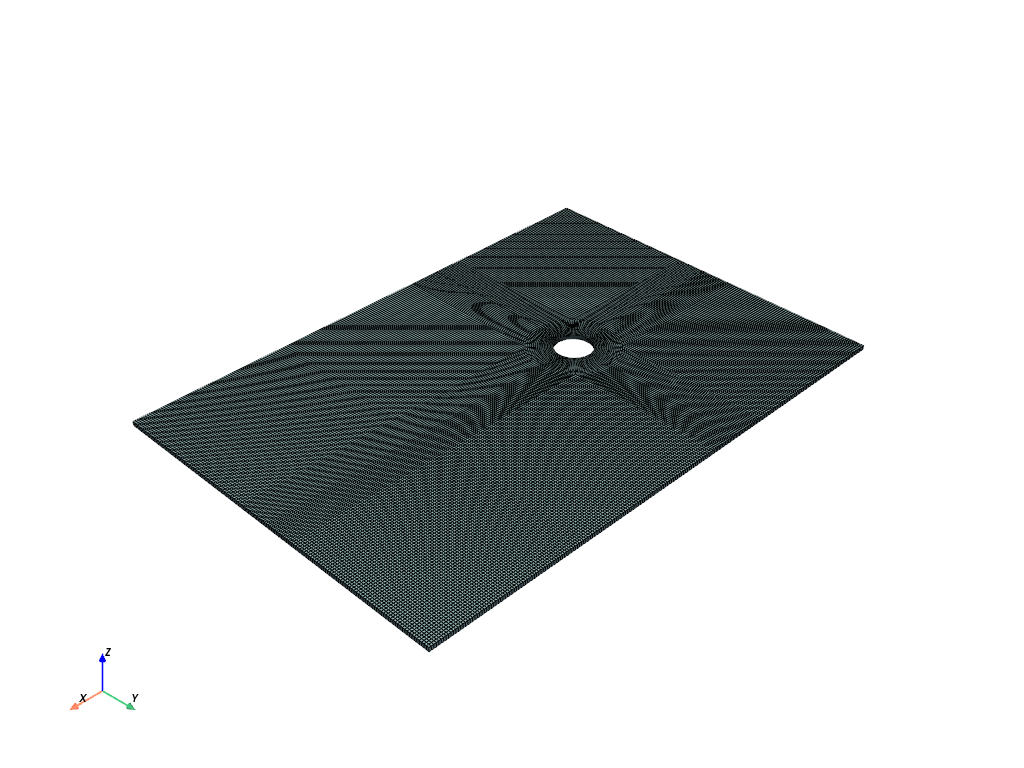

UnstructuredGrid,Information
N Cells,34764
N Points,70396
X Bounds,"-6.075e-01, 1.120e+00"
Y Bounds,"-6.000e-01, 6.000e-01"
Z Bounds,"-7.500e-03, 7.500e-03"
N Arrays,0


In [2]:
grid = of_read.mesh()
grid.plot(show_edges=True, jupyter_backend='static') # the grid is a pyvista.UnstructuredGrid object
grid

This class can be used to import the spatial-temporal data of a specific variable (e.g. velocity, pressure, etc.) as a list of numpy arrays, one for each time instant.

The fields can be loaded either as point data or cell data.


In [3]:
import numpy as np

var_names = ['p', 'U']

snaps = dict()

for var in var_names:
    snaps[var], time_instants = of_read.import_field(var_name=var,
                                                     use_fluidfoam=False,
                                                     extract_cell_data=True,
                                                     verbose=True)
    
    snaps[var] = np.array(snaps[var]) # convert to numpy array
    print(f'Field {var} with shape {snaps[var].shape} imported.')

Field p with shape (10, 34764) imported.
Field U with shape (10, 34764, 3) imported.


These data can be later saved in `npz` files as follows. The mesh can be saved in `vtk` format.

In [4]:
np.savez_compressed('flowcyl_snaps.npz', **snaps)
of_read.save_mesh('flowcyl_mesh') # save the mesh in vtk format

## Extracting slices of the mesh and associated data
This section shows how to extract slices of the mesh and associated data at different time instants.

In [5]:
sliced_grid = grid.slice(normal='z', origin=(0, 0, 0))
sliced_grid

PolyData,Information
N Cells,34764
N Points,35198
N Strips,0
X Bounds,"-6.075e-01, 1.120e+00"
Y Bounds,"-6.000e-01, 6.000e-01"
Z Bounds,"0.000e+00, 0.000e+00"
N Arrays,0


A similar procedure can be applied to each field in the OpenFOAM case.

In [6]:
sliced_snaps = dict()

for var in var_names:
    sliced_snaps[var] = []
    for _snap in snaps[var]:
        grid[var] = _snap
        sliced_grid = grid.slice(normal='z', origin=(0, 0, 0))
        sliced_snaps[var].append(sliced_grid[var])
    sliced_snaps[var] = np.array(sliced_snaps[var])
    print(f'Sliced field {var} with shape {sliced_snaps[var].shape} imported.')

Sliced field p with shape (10, 34764) imported.
Sliced field U with shape (10, 34764, 3) imported.


These data can be later saved in `npz` files as follows.

In [7]:
np.savez_compressed('flowcyl_sliced_snaps.npz', **sliced_snaps)
sliced_grid.clear_data()
sliced_grid.save('flowcyl_sliced_mesh.vtk') # save the sliced mesh in vtk format